# Cleaned Dataset

CleanedDataset(.csv): https://drive.google.com/open?id=1pyyNswPtU9J6vYGZGAJss_u7704S82Do
ExperimentResults(.csv):https://docs.google.com/spreadsheets/d/1sYVVqwnPrhTWFtEl3k4xBjvTRO3fccQcOHQkYHB-_Vs/edit?usp=sharing
ResearchWork(.pdf):https://drive.google.com/open?id=1ptPcXJNDfrtKmhRkHFp_MmMNAzkDs1SX

In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
#import the new one
data = pd.read_csv('clean_dataset.csv')

# Preprocessing

In [3]:
#Missing value: Drop the reviews with missing value directly.
data.dropna(inplace = True)
data.drop('Unnamed: 0', 1, inplace =True)
data.reset_index(drop = True, inplace = True)
#500717 records

In [4]:
#One-side Reviews: Remove the review with "No Negative"/"No Positive". 
data['NegativeReview'].replace('No Negative', "", inplace = True)
data['PositiveReview'].replace('No Positive', "", inplace = True)

In [5]:
#Combine: Positive and negative reviews would be treated as only a review, and in addition : lower the case. 
corpus = data.NegativeReview + data.PositiveReview
data.insert(0, "Review", corpus.str.lower())

In [6]:
#Tokenization: Conduct the work_tokenize first. (sent_tokenizing is more complicated in this case.)
from nltk.tokenize import sent_tokenize, word_tokenize
#data = data.join(data.TEXT.apply(sent_tokenize).rename('SENTENCES'))
#sent = data.NegativeReview.apply(sent_tokenize)
word_tokenized = data.Review.apply(word_tokenize)
data.insert(0, "WordToken", word_tokenized)

In [7]:
data.head()

,WordToken,Review,NegativeReview,PositiveReview,TripStyle
0,"[i, am, so, angry, that, i, made, this, post, ...",i am so angry that i made this post available...,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,Leisure
1,"[no, real, complaints, the, hotel, was, great,...",no real complaints the hotel was great great ...,,No real complaints the hotel was great great ...,Leisure
2,"[rooms, are, nice, but, for, elderly, a, bit, ...",rooms are nice but for elderly a bit difficul...,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,Leisure
3,"[my, room, was, dirty, and, i, was, afraid, to...",my room was dirty and i was afraid to walk ba...,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,Leisure
4,"[you, when, i, booked, with, your, company, on...",you when i booked with your company on line y...,You When I booked with your company on line y...,Amazing location and building Romantic setting,Leisure


In [8]:
#Anomaly, Weird records: Drop the empty review(or we could remove the review with less than 5 words?)
word_count = data.WordToken.apply(lambda x: len(x))
filter_count = (word_count >= 1) #if 5, remained 462350
data = data[filter_count]
data.reset_index(drop = True, inplace = True)
#Now the total records are 500487

In [9]:
#StopWordRemoval: Remove the NLTK build-in stopwords in all the records.
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
#wosw = data.WordToken.apply(lambda x:  [item for item in x if item not in stop_words])

In [10]:
#Lemmatization: Convert the terms with different representations into the original.
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
def lemmatize_text(text):
    return [wnl.lemmatize(w) for w in text]

data.insert(0, 'Lemmatized',data.WordToken.apply(lemmatize_text))

In [11]:
#Add the word count feature.
data.insert(0, 'WordCount', data.WordToken.apply(lambda x: len(x)))

# Split dataset into train/test set

In [12]:
#Split them into train/test set, randomly with the test size 0.33 (same distribution of each class)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, stratify = data['TripStyle'], test_size=0.33, random_state = 1)

col = ['NegativeReview', 'PositiveReview']
train.drop(col, 1, inplace = True)
test.drop(col, 1, inplace = True)

train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

#335K v.s. 165K(train/test split with stratified 0.83 of majority)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
#Undersampling
#from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(random_state = 1)
#x_train, lbl_train = rus.fit_resample(x_train, lbl_train)

In [12]:
#DOING SOME OUTLIER REMOVAL IN TRAINING SET
#word_count = train.WordToken.apply(lambda x: len(x))
#filter_count = (word_count >= 3) #if 5, remained 462350
#train = train[filter_count]
#train.reset_index(drop = True, inplace = True)
#Now the total records are 500487
#325729 now

In [13]:
#Labeling
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
lbl_train, lbl_test = le.fit_transform(train.TripStyle), le.transform(test.TripStyle)

# Feature Engineering

A. Origianl Framework
    1. TFIDF
    2. W2V
    
B. Experiment
    1. One-class fitting: minority
    2. Combination: WordCount included
    3. POS filtering
    4. Preprocessing: NER like tokenized
    5. Combination: TFIDF + W2V 
    
C. Feature Selection
    1. Supervised Approach: ANOVA F test: f_classif
    

# Original Experiment: Testing Here

In [14]:
#TFIDF original

def dum(doc):
    return doc

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
                             ngram_range = (1,1),
                             tokenizer = dum, 
                             preprocessor = dum,
                             min_df = 0.01)

x_ = vectorizer.fit_transform(train.WordToken)

#Implement GC

In [15]:
from sklearn.preprocessing import StandardScaler
idf_dict = vectorizer.idf_[:, np.newaxis]
ss = StandardScaler()
weight = ss.fit_transform(idf_dict)

dictionary = dict(zip(vectorizer.get_feature_names(), weight.flatten()))

In [16]:
def idfweight(termlist):
    wl = []
    for word in termlist:
        if word in dictionary.keys():
            wl.append(dictionary[word])
        else:
            wl.append(1)
    return wl

In [50]:
#W2V origianl

from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
model = Word2Vec(size = 300, window = 2, min_count = 1)
#In order to count the single-word review, cfg with two word window and one count.

#Building the dictionary.
model.build_vocab(train.WordToken)

#Train the w2v model with WordWokens

model.train(train.WordToken, total_examples = len(train.WordToken), epochs = 3)
model.init_sims(replace = True)

#To lower the memory usage, save/load in KV model is necessary...
fpath = get_tmpfile("w2v.kv")
model.wv.save(fpath)
del model
wv = KeyedVectors.load(fpath, mmap='r')

#Document vector: By simply get the average of the wordvec in the single doc.
def doc_vec(doc, mean = np.zeros(wv.vector_size)):  
    doc = [word for word in doc] # target input list of words
    #v = wv[doc] #orginal vector from word embedding
    #w = np.array(idfweight(doc))[:, np.newaxis] #idf-weighting approach
    try:
        return np.mean(wv[doc], axis = 0)
       # return np.mean(np.multiply(wv[doc] , np.array(idfweight(doc))[:, np.newaxis]), axis = 0)
    except:
        return mean  #13168/165161 is zero vector

x_train = np.vstack(train.WordToken.apply(doc_vec))  #not sure abou whether a more efficient way
mean = np.mean(x_train, axis = 0)

#TRY TO DO SOMETHING ON UNKNOWN WORD
x_test = np.vstack(test.WordToken.apply(lambda x : doc_vec(x, mean) ))  #not sure abou whether a more efficient way

# (1st NOW) Experiment I - Fit on Business-Labeled data only

In [14]:
#Vectorize II-3: Bow with TFIDF transformation.

def dum(doc):
    return doc

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
                             ngram_range = (1,2),
                             tokenizer = dum, 
                             preprocessor = dum,
                             min_df = 0.001,
                             max_df = 0.4)

bt = train[train.TripStyle == 'Business']
x = vectorizer.fit(bt.WordToken)
x_ = vectorizer.transform(train.WordToken)
x_train = x_.toarray()
x_test = vectorizer.transform(test.WordToken).toarray()

#Implement GC
del x

# Experiment II - WordCount included

In [656]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

#a = scaler.fit_transform(train.WordCount[:, np.newaxis])  # fit does nothing.
#b = scaler.transform(test.WordCount[:, np.newaxis])
a = np.array(train.WordCount).reshape(len(train.WordCount), 1) # fit does nothing.
b = np.array(test.WordCount).reshape(len(test.WordCount), 1)

In [657]:
kbin = KBinsDiscretizer(n_bins = 17, encode = 'onehot-dense', strategy = 'quantile')
a = kbin.fit_transform(a) 
b = kbin.transform(b)

In [674]:
#Cobiine the wordcount in to be treated as the feature.
x_train = np.append(x_train, a, axis = 1)
x_test = np.append(x_test, b , axis = 1)

# Experiment III - Part of speech filtering

In [ ]:
#POS filter: Remaining some important words only, filtered others.
#Warning: It took lots of time

def pos_tagging(sent):
    tagfilter = {'NOUN'}
    target = [item for (item, tag) in nltk.pos_tag(sent, tagset = 'universal') if tag in tagfilter]
    return target

data.insert(0, 'POS', data.Lemmatized.apply(pos_tagging))

## Feature Selection

In [15]:
#Feature Selection: Fitting the ANOVA stats on training data(only doing on testing data.)
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold, chi2

def FeatureSelect_f(feature, target, d):
    fs = SelectKBest(f_classif, k = d).fit(feature, target)
    return fs

#Supervised approach
fs = FeatureSelect_f(x_train, lbl_train, 500)
#Transform both training/testing set into new selected-form.
x_train = fs.transform(x_train)
x_test = fs.transform(x_test)

#Unsupervised approach

# Experiment IV - Preprocess work, special terms tokenization

In [667]:
def NumTokenized(sent):
    regex = "\d"
    t = [re.sub("\d+", "<num>", line) for line in sent]
    return t 
data.insert(0, 'NER', data.WordToken.apply(NumTokenized))

NameError: name 'NumTokenizedl' is not defined

# Experiment V - Just combine them

In [ ]:
#Execute each of the vectorization approach to two variables
#Assign the new feature vectors(combination) to x_train, x_test
x_train = np.append(x_train1, x_train, axis = 1)
x_test = np.append(x_test1, x_test, axis = 1)
#Dimentionality is 300+434 = 734

# Modeling

-Supervised
1. Naive Bayes: Gaussian


-Unsupervised
1. LDA
2. Sentense clustering



In [16]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
clf_gnb.fit(x_train, lbl_train)

GaussianNB(priors=None, var_smoothing=1e-09)

# Evaluation

1. Original
2. Imblanced Problem included

In [17]:
#Evaluation function:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
#ref: https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used
def evaluating(truth, pred, ax=object):
  
    print(accuracy_score(truth, pred))
    print(classification_report_imbalanced(truth, pred))    
    print(confusion_matrix(truth, pred))
    precision, recall, threshold = precision_recall_curve(truth, pred)

    ax.step(recall, precision, color='b', alpha=1, where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.5, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve')
    return ax
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

0.7449034578381095
                   pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.43      0.81      0.36      0.59      0.34     27350
          1       0.88      0.81      0.43      0.84      0.59      0.36    137811

avg / total       0.78      0.74      0.49      0.76      0.59      0.36    165161

[[ 11812  15538]
 [ 26594 111217]]


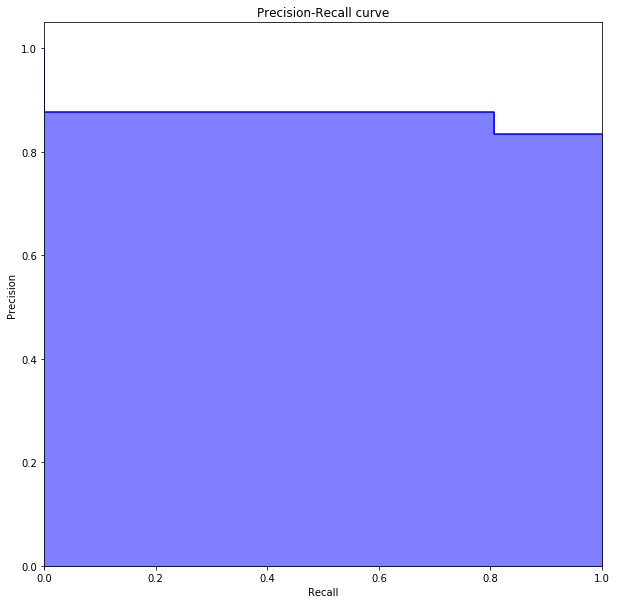

In [18]:
f, (ax1) = plt.subplots(1, 1, figsize=(10,10))

pred_gnb = clf_gnb.predict(x_test)
evaluating(lbl_test, pred_gnb, ax1)

# Imbalanced Problem
#137K v.s. 27K

# Unsupervised Approach: LDA modeling

In [ ]:
from gensim import corpora
import gensim

In [340]:
tagged_sentences = [nltk.pos_tag(sentence) for sentence in test]
ne_chunked_sents = [nltk.ne_chunk(tagged) for tagged in tagged_sentences]

In [286]:
id2word = corpora.Dictionary(train.Lemmatized)

In [289]:
texts = train.Lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [318]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 20, 
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha='auto',
                                           per_word_topics = True)

KeyboardInterrupt: 

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]